In [1]:
from utils import *

In [2]:
components0, components1 = generate_remapping_components(use_distorted_jar=False)

# Create a scene where the indices of refraction of refractive elements are slightly different
diff_iors={
    'sapphire_ior': 1.77*0.99,
    'quartz_ior': 1.458*0.99,
    'CF4_ior': 1.22*0.99,
    'Ar_ior': 1.17*0.99,
    'vacuum_ior': 1.0,
}
materials_diff_iors = create_materials(with_fluids=True, iors=diff_iors)
components2 = load_components(materials_diff_iors)

# Optional use: distorted jar surfaces
materials = create_materials(with_fluids=True)
components3 = load_components(materials=materials, use_distorted_jar=True)

spp=16
c1 = create_sensor(sensor_number=1, sample_count=spp)
c2 = create_sensor(sensor_number=2, sample_count=spp)
c3 = create_sensor(sensor_number=3, sample_count=spp)

# Extract projection matrices from sensors
c1pose = np.array(c1['to_world'].matrix)[:3,:]
c2pose = np.array(c2['to_world'].matrix)[:3,:]
c3pose = np.array(c3['to_world'].matrix)[:3,:]

# # Optionally use estimated pose matrices
# estimated_poses_loc = "outputs/estimated_pose_matrices/"
# c1pose = np.load(estimated_poses_loc+"c1posep.npy")
# c2pose = np.load(estimated_poses_loc+"c2posep.npy")
# c3pose = np.load(estimated_poses_loc+"c3posep.npy")

poses = np.stack([c1pose, c2pose, c3pose], axis=0)
print(poses)

2024-08-07 19:42:15 WARN main [PLYMesh] "outer_jar_outer_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-07 19:42:15 WARN main [PLYMesh] "outer_jar_inner_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-07 19:42:15 WARN main [PLYMesh] "inner_jar_outer_surface_bottom.ply": skipping unknown element "edge"

2024-08-07 19:42:16 WARN main [PLYMesh] "outer_jar_outer_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-07 19:42:16 WARN main [PLYMesh] "outer_jar_inner_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-07 19:42:16 WARN main [PLYMesh] "inner_jar_outer_surface_bottom.ply": skipping unknown element "edge"

[[[-6.56510830e-01 -7.29643881e-01  1.91346124e-01 -5.96334600e+00]
  [-6.56510830e-01  6.77617311e-01  3.31403643e-01 -1.03287039e+01]
  [-3.71466011e-01  9.19492841e-02 -9.23882246e-01  1.78488827e+01]]

 [[ 9.23874855e-01 -8.44208353e-06 -3.82694721e-01  1.19286947e+01]
  [ 0.00000000e+00 -1.00000000e+00  2.20595775e-05 -2.20595775e-05]
  [-3.82694721e-01 -2.03802883e-05 -9.23874855e-01  1.78498745e+01]]

 [[-6.56507790e-01  7.29646504e-01  1.91346720e-01 -5.96384668e+00]
  [ 6.56507790e-01  6.77613378e-01 -3.31417680e-01  1.03296175e+01]
  [-3.71476769e-01 -9.19576734e-02 -9.23877120e-01  1.78518772e+01]]]


1000


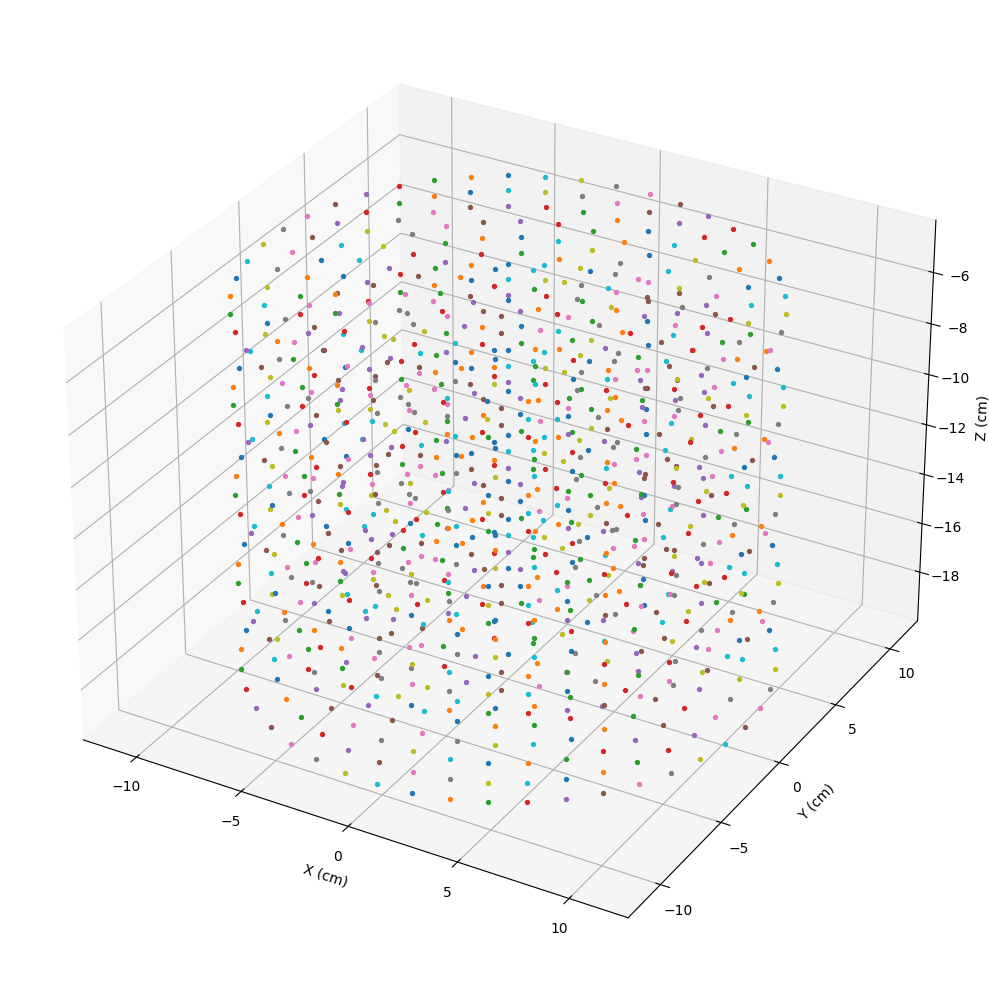

In [3]:
cparams = {
    'radius': 11.0,
    'height': 14.0,
    'rcount': 8,
    'mtcount': 45,
    'hcount':  5,
    'origin': [0.0, 0.0, -12.0],
}

# cparams = default_cylindrical_grid_params
grid = generate_cylindrical_grid(**cparams)
print(len(grid))
visualize_grid(grid)

11.0


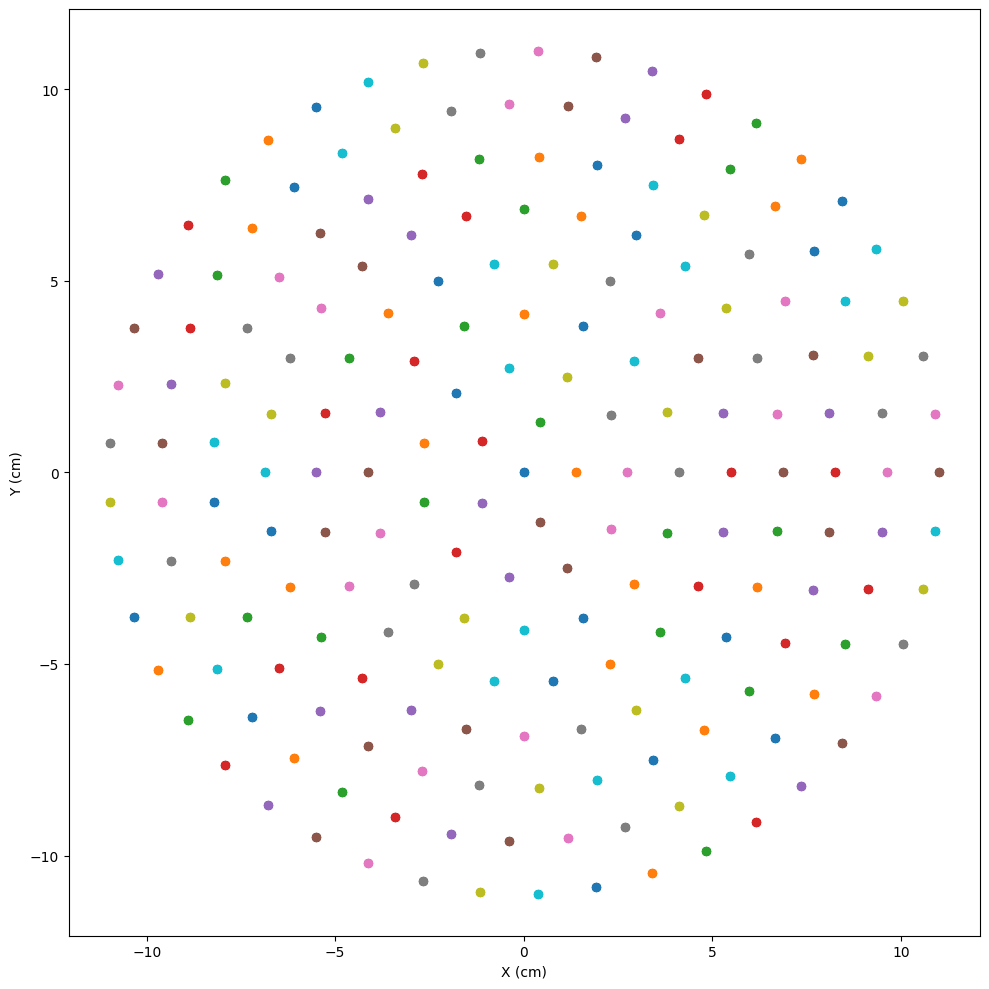

In [4]:
visualize_grid_2d(grid)
print(np.max(np.array(grid)[:,0]))

In [5]:
# locs_dir = "outputs/grid_pixel_locations/predicted_proj_mats_w_ideal_jar_surface/"
# locs_dir = "outputs/grid_pixel_locations/predicted_proj_mats_w_distorted_jar_surface/"
locs_dir = "outputs/grid_pixel_locations/actual_proj_mats_w_ideal_jar_surface/"
# locs_dir = "outputs/grid_pixel_locations/actual_proj_mats_w_distorted_jar_surface/"

loc_names = ['c1loc0', 'c1loc1', 'c1loc2', 'c2loc0', 'c2loc1', 'c2loc2', 'c3loc0', 'c3loc1', 'c3loc2'] 
cs = [c1, c1, c1, c2, c2, c2, c3, c3, c3]
comps = [components0, components1, components2, 
         components0, components1, components2, 
         components0, components1, components2]

locs = []
i = 0
for c in cs:
    try:
        # Try to load if the file already exists
        locs.append(np.load(locs_dir+loc_names[i]+".npy", allow_pickle=True))
    except OSError:
        # Otherwise, calculate and save
        loc = rendered_grid_projections(comps[i], c, grid, remapping_default_config)
        np.save(locs_dir+loc_names[i]+".npy", np.array(loc))
        locs.append(loc)
    i += 1

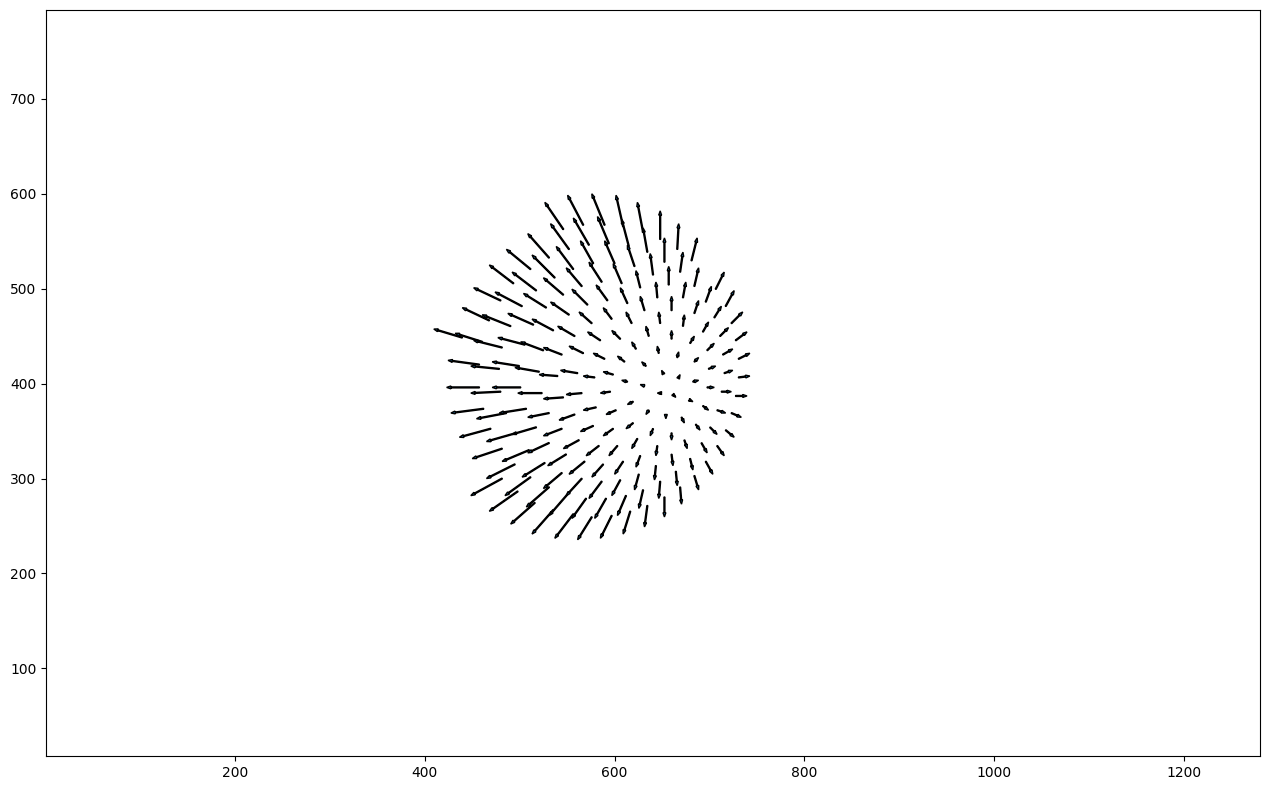

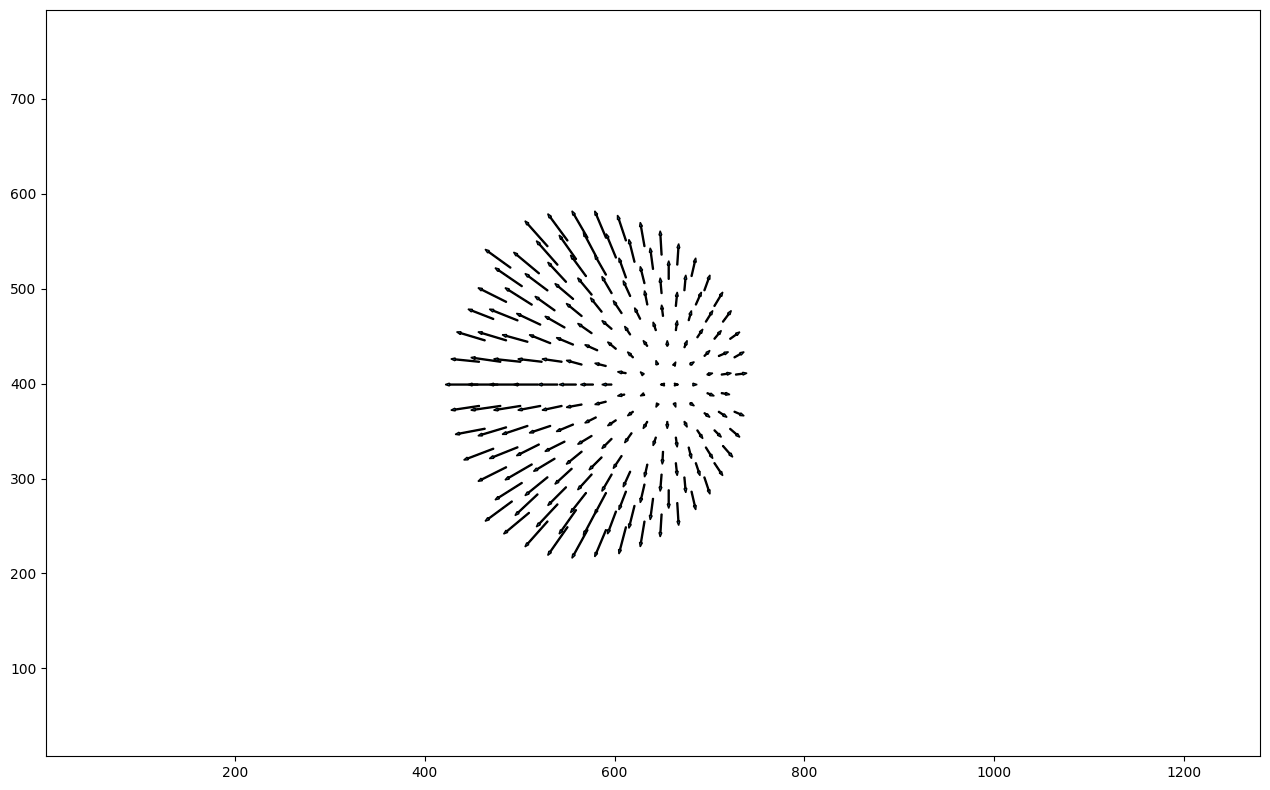

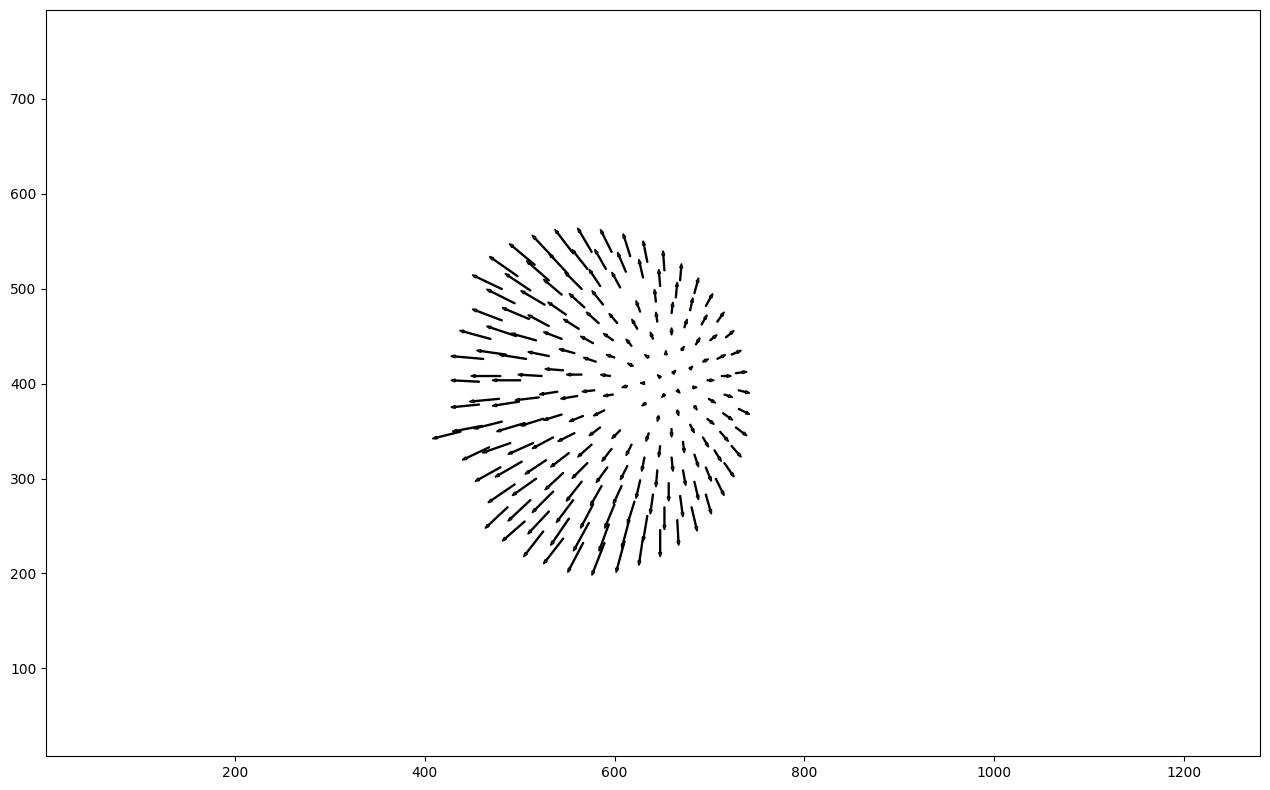

In [6]:
plot_remapping_arrows(locs[0][:200], locs[1][:200])
plot_remapping_arrows(locs[3][:200], locs[4][:200])
plot_remapping_arrows(locs[6][:200], locs[7][:200])

In [7]:
# project the points directly onto the image plane
actualp1 = []
actualp2 = []
actualp3 = []
inv_poses = compute_inverse_pose_matrices(poses)
for g in grid:
    actualp1.append(normalized_to_pixel(reproject(inv_poses[0], g)))
    actualp2.append(normalized_to_pixel(reproject(inv_poses[1], g)))
    actualp3.append(normalized_to_pixel(reproject(inv_poses[2], g)))
actualp1 = np.array(actualp1)
actualp2 = np.array(actualp2)
actualp3 = np.array(actualp3)

In [8]:
use_wrong_iors = False

lc1 = compute_linear_distortion_coeffs(actualp1, locs[1])
lc2 = compute_linear_distortion_coeffs(actualp2, locs[4])
lc3 = compute_linear_distortion_coeffs(actualp3, locs[7])

pc1 = compute_polynomial_distortion_coeffs(actualp1, locs[1])
pc2 = compute_polynomial_distortion_coeffs(actualp2, locs[4])
pc3 = compute_polynomial_distortion_coeffs(actualp3, locs[7])

pce1 = compute_polynomial_extended_distortion_coeffs(actualp1, locs[1])
pce2 = compute_polynomial_extended_distortion_coeffs(actualp2, locs[4])
pce3 = compute_polynomial_extended_distortion_coeffs(actualp3, locs[7])

if use_wrong_iors:
    lc1 = compute_linear_distortion_coeffs(actualp1, locs[2])
    lc2 = compute_linear_distortion_coeffs(actualp2, locs[5])
    lc3 = compute_linear_distortion_coeffs(actualp3, locs[8])

    pc1 = compute_polynomial_distortion_coeffs(actualp1, locs[2])
    pc2 = compute_polynomial_distortion_coeffs(actualp2, locs[5])
    pc3 = compute_polynomial_distortion_coeffs(actualp3, locs[8])

    pce1 = compute_polynomial_extended_distortion_coeffs(actualp1, locs[2])
    pce2 = compute_polynomial_extended_distortion_coeffs(actualp2, locs[5])
    pce3 = compute_polynomial_extended_distortion_coeffs(actualp3, locs[8])

print(lc1)
print(lc2)
print(lc3)

print(pc1)
print(pc2)
print(pc3)

print(pce1)
print(pce2)
print(pce3)

[[109.26900282]
 [  0.83228836]
 [ 67.80594852]
 [  0.83051834]]
[[109.03958194]
 [  0.83274771]
 [ 68.12322804]
 [  0.83080502]]
[[108.79725803]
 [  0.83297389]
 [ 68.98521202]
 [  0.82938641]]
[[ 1.17866991e+02]
 [ 7.65458730e-01]
 [ 1.14414142e-04]
 [-7.09592872e-11]
 [ 8.58342736e+01]
 [ 6.95925500e-01]
 [ 2.62456692e-04]
 [-2.49004611e-10]]
[[ 1.12227827e+02]
 [ 7.87580610e-01]
 [ 9.05555964e-05]
 [-6.28794387e-11]
 [ 8.51692852e+01]
 [ 6.99275902e-01]
 [ 2.64342083e-04]
 [-2.64385025e-10]]
[[ 1.16878863e+02]
 [ 7.68122700e-01]
 [ 1.12710197e-04]
 [-7.11981398e-11]
 [ 8.38975216e+01]
 [ 7.09225879e-01]
 [ 2.49860426e-04]
 [-2.61608347e-10]]
[[-3.49158725e+02]
 [ 3.45537900e+00]
 [-4.43771207e-03]
 [ 5.10938656e-09]
 [-4.43286773e-15]
 [ 1.60244942e-21]
 [ 1.00413118e+02]
 [ 5.35758207e-01]
 [ 7.55815323e-04]
 [-1.91347035e-09]
 [ 3.79183504e-15]
 [-3.39366504e-21]]
[[-5.14388928e+02]
 [ 4.40274698e+00]
 [-6.04596413e-03]
 [ 6.98912125e-09]
 [-6.11985977e-15]
 [ 2.25164638e-21]
 [ 

1.465560889796389


Text(0.5, 1.0, 'Ideal Jar Surface and Ground Truth Pose\n Fit Using Extended Polynomial Distortion Model\nAverage Remapping Error: 1.4656 pixels')

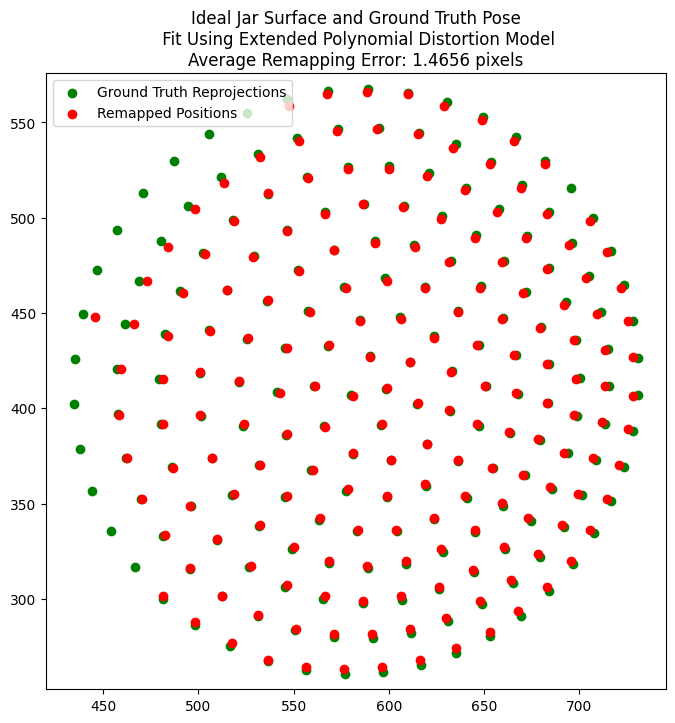

In [14]:
undistort_points = 5
actual_mode = 0
undistort_mode = ""

if undistort_points == 0: # compare to predicted position using OpenCV with no distortive elements
    undistort_mode = "Using OpenCV Estimated Pixel Positions With No Distortive Elements"
    up1 = locs[0]
    up2 = locs[3]
    up3 = locs[6]
elif undistort_points == 1: # compare to predicted position using OpenCV with distortive elements
    undistort_mode = "Using OpenCV Estimated Pixel Positions With Distortive Elements"
    up1 = locs[1]
    up2 = locs[4]
    up3 = locs[7]
elif undistort_points == 2: # compare to predicted position using OpenCV with distortive elements and wrong IoRs
    undistort_mode = "Using OpenCV Estimated Pixel Positions With Distortive Elements With Wrong IoRs"
    up1 = locs[2]
    up2 = locs[5]
    up3 = locs[8]
elif undistort_points == 3: # use the linear distortion coefficients to undistort the points computed by opencv
    undistort_mode = "Using Linear Distortion Model"
    up1 = linear_undistort(locs[1], lc1)
    up2 = linear_undistort(locs[4], lc2)
    up3 = linear_undistort(locs[7], lc3)
elif undistort_points == 4: # use the polynomial distortion coefficients to undistort the points computed by opencv
    undistort_mode = "Using Polynomial Distortion Model"
    up1 = polynomial_undistort(locs[1], pc1)
    up2 = polynomial_undistort(locs[4], pc2)
    up3 = polynomial_undistort(locs[7], pc3)
elif undistort_points == 5: # use the extended polynomial distortion coefficients to undistort the points computed by opencv
    undistort_mode = "Using Extended Polynomial Distortion Model"
    up1 = polynomial_extended_undistort(locs[1], pce1)
    up2 = polynomial_extended_undistort(locs[4], pce2)
    up3 = polynomial_extended_undistort(locs[7], pce3)


projected = np.array(up1)

actual_mode_d = ""
if actual_mode == 0: # Use exact reprojections
    actual = np.array(actualp1)
    actual_mode_d = "Ground Truth Reprojections"
elif actual_mode == 1: # Use OpenCV predicted positions without refractive elements
    actual = np.array(locs[0])
    actual_mode_d = "OpenCV Predicted Positions"
elif actual_mode == 2: # Use OpenCV predicted positions with refractive elements
    actual = np.array(locs[1])

remapping_errors = []
for i in range(actual.shape[0]):
    if np.all(projected[i]) and np.all(actual[i]):
        remapping_errors.append(np.linalg.norm(actual[i] - projected[i]))
avg_remapping_error = np.average(np.array(remapping_errors))
print(avg_remapping_error)

# jar_surface_mode = "Distorted Jar Surface and Estimated Pose"
jar_surface_mode = "Ideal Jar Surface and Ground Truth Pose"
plt.figure(figsize=(8,8))
plt.scatter(actual[:200,0], actual[:200,1], c='g', label=actual_mode_d)
plt.scatter(projected[:200,0], projected[:200,1], c='r', label="Remapped Positions")
plt.axis('equal')
plt.legend()
plt.title(jar_surface_mode+"\n Fit "+undistort_mode+"\nAverage Remapping Error: " + "{:.4f}".format(avg_remapping_error)+" pixels")

In [10]:
use_actual_reprojections = False
random_pixel_offset = 0.0
opt_name = ""

# idk why Im sticking with the full names here but oh well
predictions = {
    'N-view Triangulation': [],
    'N-view Triangulation with Basic Gradient Descent': [],
    'N-view Triangulation with Basic Gradient Descent and Delta Scaling': [],
    'N-view Triangulation with Gradient Descent': [],
    'N-view Triangulation with Gradient Descent and Delta Scaling': [],
    'N-view Triangulation with Levenberg-Marquardt': []
}
losseses = {
    'N-view Triangulation': [],
    'N-view Triangulation with Basic Gradient Descent': [],
    'N-view Triangulation with Basic Gradient Descent and Delta Scaling': [],
    'N-view Triangulation with Gradient Descent': [],
    'N-view Triangulation with Gradient Descent and Delta Scaling': [],
    'N-view Triangulation with Levenberg-Marquardt': []
}

print("Number of points: ", up1.shape[0])
for i in range(up1.shape[0]):
    if use_actual_reprojections:
        clocs = np.stack([actualp1[i], actualp2[i], actualp3[i]])
    else:
        clocs = np.stack([up1[i], up2[i], up3[i]], axis=0)

    if np.all(clocs != None):

        clocs = np.array([normalize_coordinate(random_pixel_offset*random_in_unit_circle() + c) for c in clocs])

        predictions['N-view Triangulation'].append(n_view_triangulate(poses, clocs))
    
        pred, _, losses = gradient_descent_optimization(poses, clocs, iterations=100, delta=0.0005, scale_delta=False)
        predictions['N-view Triangulation with Basic Gradient Descent'].append(pred)
        losseses['N-view Triangulation with Basic Gradient Descent'].append(losses)

        pred, _, losses = gradient_descent_optimization(poses, clocs, iterations=100, delta=0.001, scale_delta=True)
        predictions['N-view Triangulation with Basic Gradient Descent and Delta Scaling'].append(pred)
        losseses['N-view Triangulation with Basic Gradient Descent and Delta Scaling'].append(losses)

        pred, _, losses = gradient_descent_optimization(poses, clocs, iterations=100, delta=0.01, scale_delta=False, basic_mode=False)
        predictions['N-view Triangulation with Gradient Descent'].append(pred)
        losseses['N-view Triangulation with Gradient Descent'].append(losses)

        pred, _, losses = gradient_descent_optimization(poses, clocs, iterations=100, delta=0.1, scale_delta=True, basic_mode=False)
        predictions['N-view Triangulation with Gradient Descent and Delta Scaling'].append(pred)
        losseses['N-view Triangulation with Gradient Descent and Delta Scaling'].append(losses)


        pred, _, losses = levenberg_marquardt_optimization(poses, clocs, iterations=20, delta=0.0001, lmb=1.0, scale_lmb=2.0)
        predictions['N-view Triangulation with Levenberg-Marquardt'].append(pred)
        losseses['N-view Triangulation with Levenberg-Marquardt'].append(losses)

    else:
        predictions['N-view Triangulation'].append(np.array([None, None, None]))
        predictions['N-view Triangulation with Basic Gradient Descent'].append(np.array([None, None, None]))
        predictions['N-view Triangulation with Basic Gradient Descent and Delta Scaling'].append(np.array([None, None, None]))
        predictions['N-view Triangulation with Gradient Descent'].append(np.array([None, None, None]))
        predictions['N-view Triangulation with Gradient Descent and Delta Scaling'].append(np.array([None, None, None]))
        predictions['N-view Triangulation with Levenberg-Marquardt'].append(np.array([None, None, None]))

    print("Current Point: ", i, end='\r')

# print(predictions)
# print(losseses)

Number of points:  1000


In [11]:
errors = {
    'N-view Triangulation': [],
    'N-view Triangulation with Basic Gradient Descent': [],
    'N-view Triangulation with Basic Gradient Descent and Delta Scaling': [],
    'N-view Triangulation with Gradient Descent': [],
    'N-view Triangulation with Gradient Descent and Delta Scaling': [],
    'N-view Triangulation with Levenberg-Marquardt': []
}

for name, preds in predictions.items():
    i = 0
    for pred in preds:
        if np.all(pred != None):
            err = np.linalg.norm(pred - grid[i])
            errors[name].append(err)
        else:
            errors[name].append(None)
        i += 1

# print(errors)

Text(0.5, 1.0, 'Ideal Jar Surface and Ground Truth Pose\n Fit Using Extended Polynomial Distortion Model\nAverage Remapping Error: 1.4656 pixels')

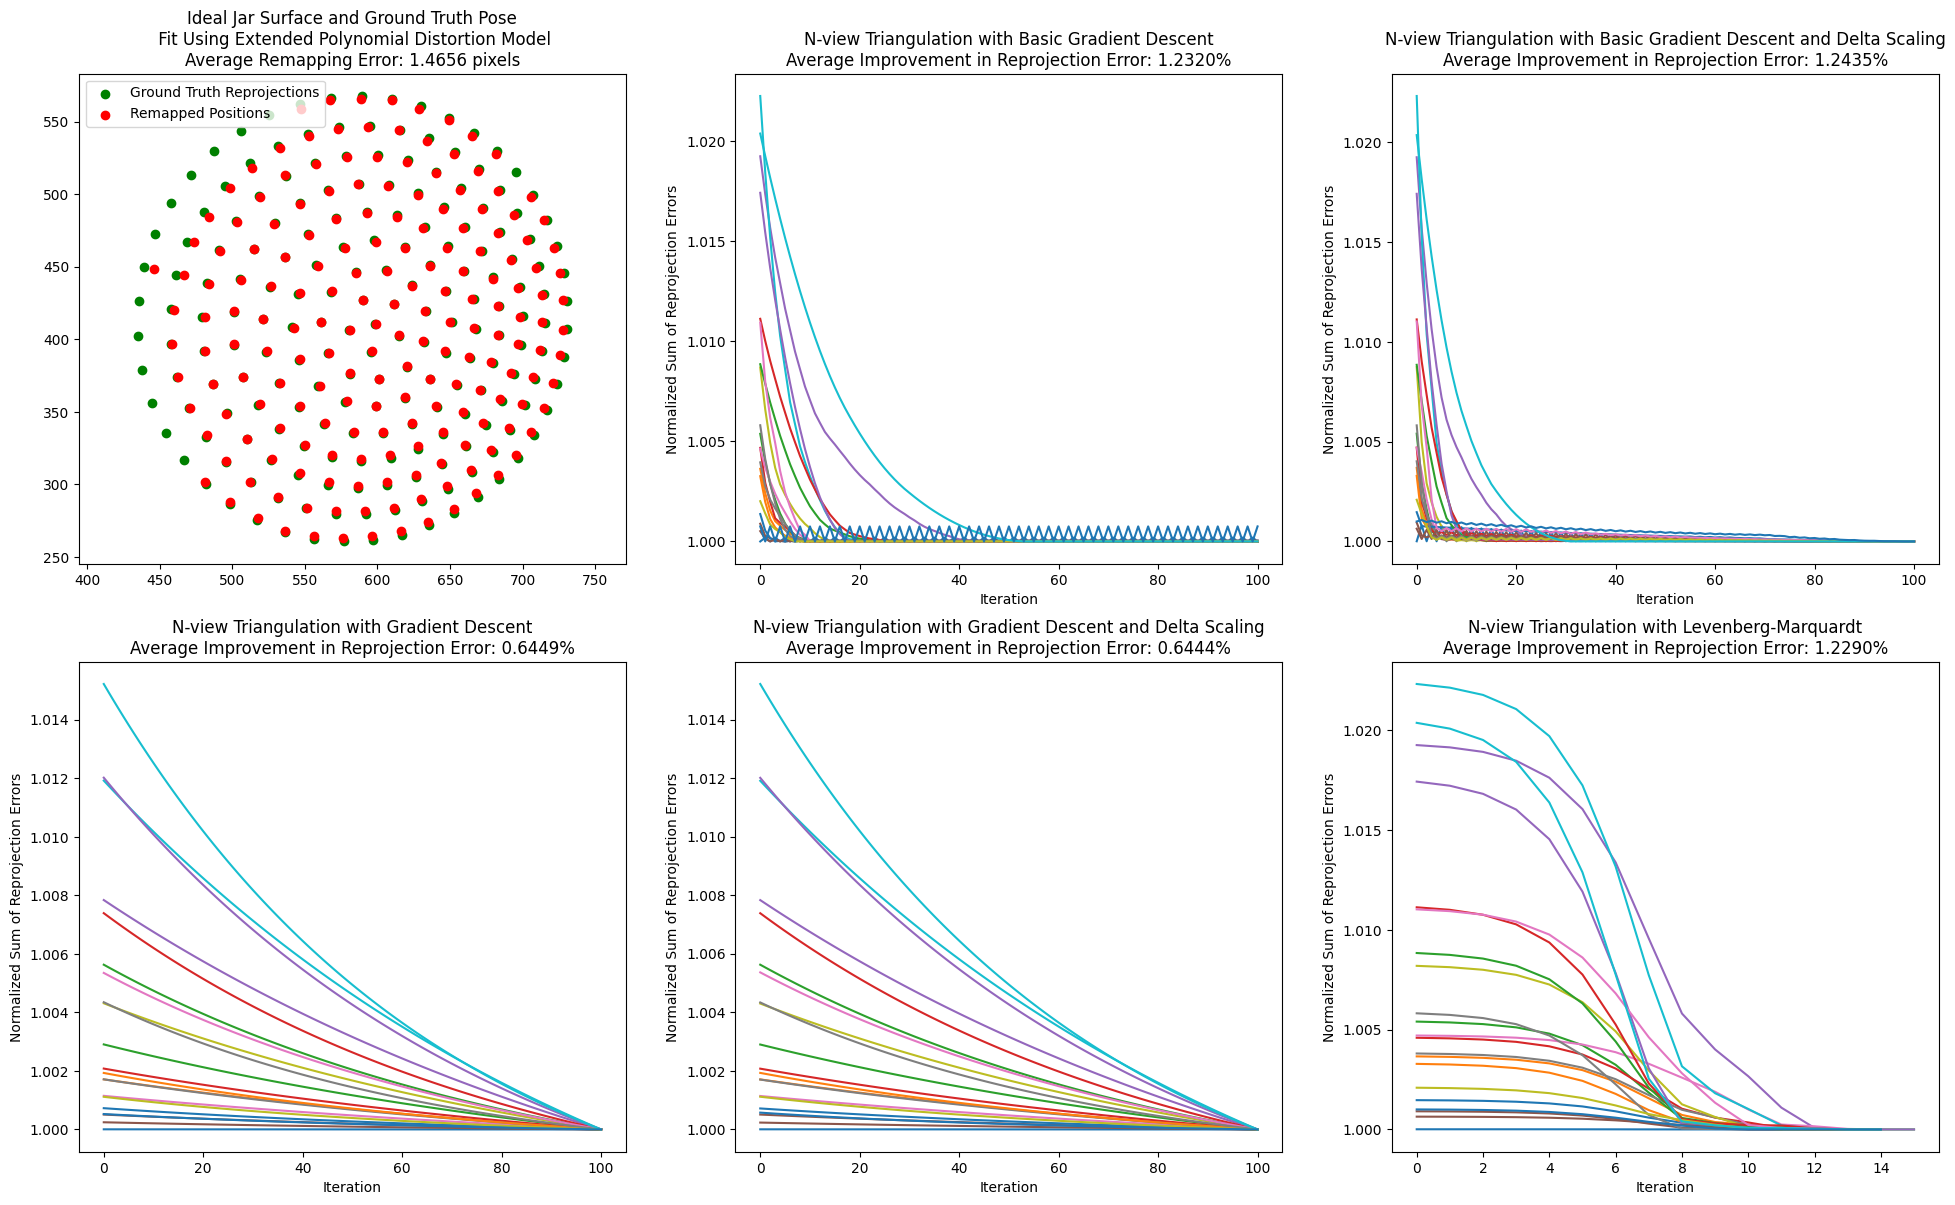

In [15]:
def draw_axes_losses(axis, opt_name):
    i = 0
    losses = losseses[opt_name]
    if len(losses) == 0:
        return
    n = len(losses)
    m = 20
    for ls in losses:
        if i%(n//m) == 0: # Choose m of the loss curves
            # ax.plot(ls)
            axis.plot(ls/np.min(ls)) # normalize by minimum loss to check convergence
        i += 1
    axis.set_xlabel("Iteration")
    axis.set_ylabel("Normalized Sum of Reprojection Errors")
    avg_improvement = (np.average(np.array([ls[0]/ls[-1] for ls in losses]))-1)*100
    axis.set_title(opt_name+"\nAverage Improvement in Reprojection Error: "+"{:.4f}".format(avg_improvement)+"%")


fig, axes = plt.subplots(2, 3, figsize=(24,14))
draw_axes_losses(axes[0][1], 'N-view Triangulation with Basic Gradient Descent')
draw_axes_losses(axes[0][2], 'N-view Triangulation with Basic Gradient Descent and Delta Scaling')
draw_axes_losses(axes[1][0], 'N-view Triangulation with Gradient Descent')
draw_axes_losses(axes[1][1], 'N-view Triangulation with Gradient Descent and Delta Scaling')
draw_axes_losses(axes[1][2], 'N-view Triangulation with Levenberg-Marquardt')

axes[0][0].scatter(actual[:200,0], actual[:200,1], c='g', label=actual_mode_d)
axes[0][0].scatter(projected[:200,0], projected[:200,1], c='r', label="Remapped Positions")
axes[0][0].axis('equal')
axes[0][0].legend()
axes[0][0].set_title(jar_surface_mode+"\n Fit "+undistort_mode+"\nAverage Remapping Error: " + "{:.4f}".format(avg_remapping_error)+" pixels")

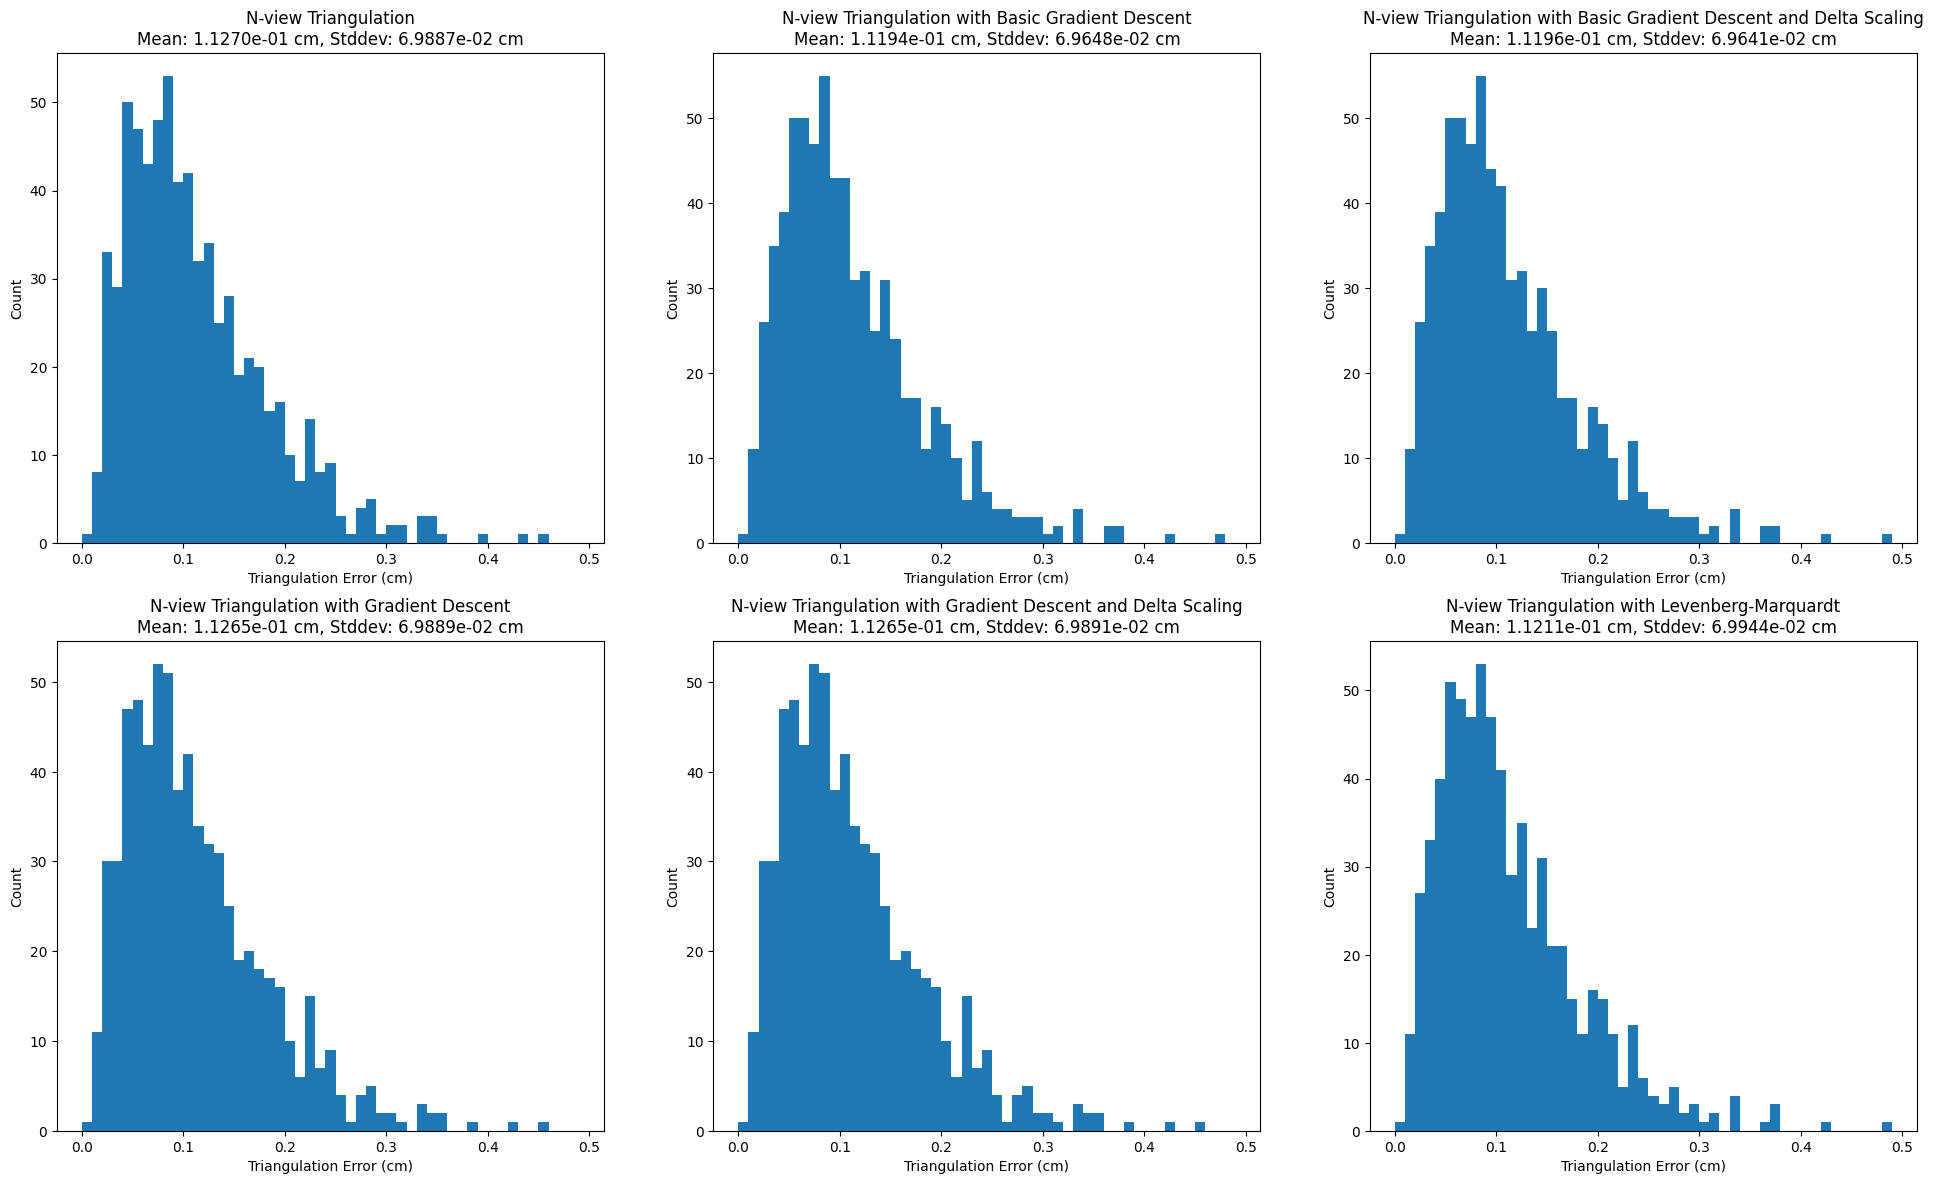

In [13]:
def draw_axes_histograms(axis, opt_name):
    errs = errors[opt_name]
    nerrors = np.array([e for e in errs if e != None])

    # Round max up to closest tenths place in error. 10 left-aligned bins per 0.1cm interval
    bins = np.arange(int(np.max(nerrors)*10+1)*10)/100

    axis.hist(nerrors, bins=bins)
    axis.set_xlabel("Triangulation Error (cm)")
    axis.set_ylabel("Count")
    axis.set_title(opt_name+"\nMean: " + "{:.4e}".format(np.mean(nerrors)) + " cm, Stddev: " + "{:.4e}".format(np.std(nerrors)) + " cm")

fig, axes = plt.subplots(2, 3, figsize=(24,14))
draw_axes_histograms(axes[0][0], 'N-view Triangulation')
draw_axes_histograms(axes[0][1], 'N-view Triangulation with Basic Gradient Descent')
draw_axes_histograms(axes[0][2], 'N-view Triangulation with Basic Gradient Descent and Delta Scaling')
draw_axes_histograms(axes[1][0], 'N-view Triangulation with Gradient Descent')
draw_axes_histograms(axes[1][1], 'N-view Triangulation with Gradient Descent and Delta Scaling')
draw_axes_histograms(axes[1][2], 'N-view Triangulation with Levenberg-Marquardt')